In [48]:
!pip install keras_tqdm

In [50]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.utils import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.python.client import device_lib

In [92]:
import sys
import tensorflow as tf
import numpy as np

print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)


Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
TensorFlow version: 2.13.0
NumPy version: 1.24.3


# Loading the Data
We have a file named 'iam_words' that contains the PNG images of the words and a text file that contains the labels for these words.


In [52]:
with open('/kaggle/input/iam-handwriting-word-database/words_new.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents][18:]

In the following code cell, we extract the file paths and their corresponding labels. This was the trickiest and most time-consuming part.


In [53]:
def filepath_label(lines):
    path_and_label = []
    for index, line in enumerate(lines):
        splits = line.split(' ')
        status = splits[1]
    
        if status == 'ok':
            word_id = splits[0]
            word = "".join(splits[8:])
        
            splits_id = word_id.split('-')
            filepath = '/kaggle/input/iam-handwriting-word-database/iam_words/words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
            path_and_label.append([filepath, word])
    return path_and_label

In [ ]:
'''
max_w = 0
min_w = 1000000000
max_h = 0
min_h = 1000000000
for img, word in filepath_label(lines):
    try:
        img = cv2.imread(img) 
        w, h, constant = img.shape
        if w > max_w :
            max_w = w
        if w < min_w:
            min_w = w
        if h > max_h :
            max_h = h
        if h < min_h:
            min_h = h
    except:
        continue
print(max_w, min_w, max_h, min_h)
'''

Here we obtain the maximum length among all the labels.

In [54]:
max_label_len = 0
for img, word in filepath_label(lines):
    if len(word) > max_label_len:
        max_label_len = len(word)
max_label_len

19

# Test-Train-Validation Split

Using a 90/10 split for training and testing, with a portion of the training set used for validation. 
The test and validation sets were supposed to have the same size, but I forgot that we excluded the lines with errors in status. Therefore, they are not the same anymore.

In [55]:
#len(lines) 44564 lines
#90/10 test train split and also validation
train_data = filepath_label(lines[:36564])
valid_data = filepath_label(lines[36564:40564])
test_data = filepath_label(lines[40564:44564])
len(train_data), len(valid_data), len(test_data)

(31536, 3495, 3274)

# Preprocess the images 
I tried several preprocessing functions. The final chosen function achieves:
We ensure that the input conforms to the required shape of (32, 128, 1) and normalizes pixel values between 0 and 1. It involves resizing the image, adding padding if needed, inverting colors, and expanding dimensions to represent a single channel (grayscale).


In [69]:
'''
def preprocess_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize with symmetric padding
    """
    target_width = 128
    target_height = 32
    
    # Resize the image while maintaining the aspect ratio
    aspect_ratio = img.shape[1] / img.shape[0]
    new_width = int(target_height * aspect_ratio)
    img = cv2.resize(img, (new_width, target_height))
    
    # Calculate padding needed on both sides
    pad_left = max(0, (target_width - new_width) // 2)
    pad_right = max(0, target_width - new_width - pad_left)
    
    # Pad with white space
    img = cv2.copyMakeBorder(img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=255)

    img = cv2.subtract(255, img)

    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255.0
    
    return img
'''

In [30]:
"""
def preprocess_image(img):
    """
    #Converts image to shape (32, 128, 1) & normalize with symmetric padding
    """
    w, h = img.shape
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Symmetric padding to ensure the final shape is (32, 128)
    
    img = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=255)

    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img
"""

In [56]:
def preprocess_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    #Resize
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    #Add zero padding to have a shape of (32,128)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    #resize again to ensure final shape
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    #invert color
    img = cv2.subtract(255, img)
    
    #add third dimenion
    img = np.expand_dims(img, axis=2)
    
    # Normalization
    img = img / 255
    
    return img

In [9]:
#img = cv2.imread(train_data[i][0], cv2.IMREAD_GRAYSCALE)
#img = preprocess_image(img)
#img = preprocess(path=train_data[i][0], img_w=128, img_h=32)
#img = combined_preprocess(train_data[i][0])
#img.shape

In [ ]:
Some exmaples:

National


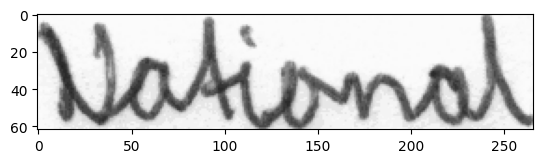

In [57]:
#original 
i = 500
print(train_data[i][1])
img = cv2.imread(train_data[i][0]) 
plt.imshow(img)

National


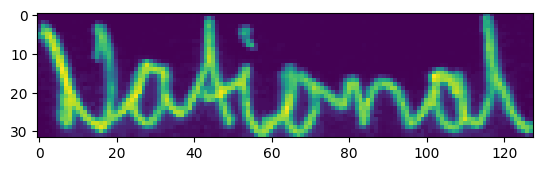

In [93]:
#processed
i = 500
print(train_data[i][1]) 
img = cv2.imread(train_data[i][0], cv2.IMREAD_GRAYSCALE)
img = preprocess_image(img)
plt.imshow(img)

,


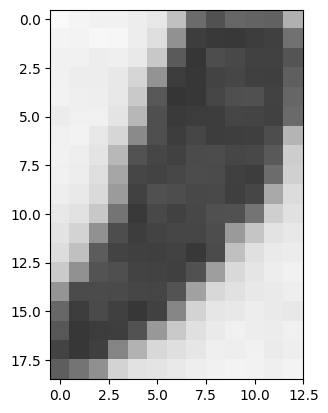

In [72]:
i = 10001
print(train_data[i][1])
img = cv2.imread(train_data[i][0]) 
plt.imshow(img)

,


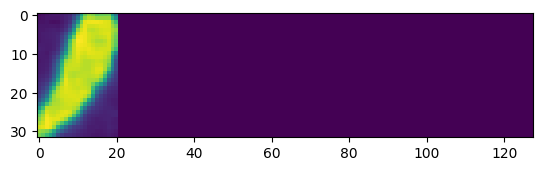

In [94]:
i = 10001
print(train_data[i][1]) 
img = cv2.imread(train_data[i][0], cv2.IMREAD_GRAYSCALE)
img = preprocess_image(img)
plt.imshow(img)

,


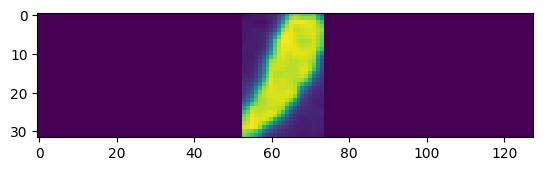

In [73]:
#that is the output of and the not used preprocess fucntion
i = 10001
print(train_data[i][1]) 
img = cv2.imread(train_data[i][0], cv2.IMREAD_GRAYSCALE)
img = preprocess_image(img)
plt.imshow(img)

The following code may not seem difficult, but it is the most essential one. I had to retrain because of a tiny error in the previous version. Here, we define a character set and a function 'encode_to_labels(txt)' that maps each character in a given text to its corresponding index in the char_set.

In [58]:

char_set = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

print(char_set, len(char_set))
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_set.index(chara))
        
    return dig_lst


!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [59]:
print(len(train_data), len(valid_data))

31536 3495


In [60]:
print(char_set, len(char_set))

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [61]:
images = []
labels = []
RECORDS_COUNT = len(train_data) + len(valid_data) + len(test_data)

Now we processes training and validation data for OCR. We iterate through the provided training and validation data, loading grayscale images and corresponding text labels. Each image is preprocessed using the function defined, and the text labels are encoded into numerical representations using the encode_to_labels function. The processed images, encoded labels, and additional information such as input and label lengths are stored in separate lists for both training and validation sets. The resulting data is crucial for training OCR models, as it converts images of text into a format suitable for machine learning, aiding in the development of accurate character recognition models. 

In [62]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

input_length = 30

for img_path, label in train_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_image(img)
        label = encode_to_labels(label)
        train_images.append(img)
        train_labels.append(label)
        train_input_length.append(input_length)
        train_label_length.append(len(word))
        train_original_text.append(label)
    except:
        continue

for img_path, label in valid_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_image(img)
        label = encode_to_labels(label)
        valid_images.append(img)
        valid_labels.append(label)
        valid_input_length.append(input_length)
        valid_label_length.append(len(word))
        valid_original_text.append(label)
    except: continue
        
print(len(train_images), len(valid_images))

31535 3495


Here we use the pad_sequences function from a sequence processing utility in Keras to pad the encoded labels in the training and validation sets. The goal is to ensure that all sequences (encoded labels) have the same length, specified by max_label_len (=19). Padding is applied at the end ('post') of each sequence, and the padding value is set to the index corresponding to the length of the character set. This process is crucial for maintaining consistent input shapes when training neural networks, where sequences of varying lengths need to be processed. The padded labels are then used for training.

In [63]:
train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_set))
valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_set))

In [64]:
train_padded_label.shape, valid_padded_label.shape

((31535, 19), (3495, 19))

We need to convert the data into arrays to be able to use the data. To achieve this, it was important that the images have the same size, I am noting that specifically beause I had problem with the prepocess function.

In [65]:
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

# The Convolutional Recurrent Neural Networt for OCR

Short Summary:
- Input Layer: Images of size (32,128,1)
- Convo Layer: Three sets of convolutional layers with increasing filters (64, 128, 256, 512) and ReLU activation, interspersed with max-pooling layers.
- Batch Normalizatio: Applied after the fith convolutional layer.
- Bidirectional LSTM Layers: Two biddirectional LSTM layers with 256 units each, aming to capture squential dependencies.
- Dense Output Layer: We use softmax activation.

In [68]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_set)+1, activation = 'softmax')(blstm_2)

act_model = Model(inputs, outputs)

In [69]:
act_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 8, 32, 128)        0         
 ng2D)                                                           
                                                                 
 conv2d_30 (Conv2D)          (None, 8, 32, 256)        2951

# CTC Loss Layer


In [70]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [71]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 32, 128, 64)          640       ['input_5[0][0]']             
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 16, 64, 64)           0         ['conv2d_28[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_29 (Conv2D)          (None, 16, 64, 128)          73856     ['max_pooling2d_16[0][0]

In [72]:
batch_size = 32
epochs = 20
e = str(epochs)
optimizer_name = 'adam'

In [73]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [74]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'false'

In [75]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=20, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=1,callbacks=callbacks_list)

Epoch 1/20
985/986 [============================>.] - ETA: 0s - loss: 11.9439 - accuracy: 0.0568
Epoch 1: val_loss improved from inf to 9.46919, saving model to adamo-38305r-20e-31535t-3495v.hdf5
986/986 [==============================] - 60s 51ms/step - loss: 11.9414 - accuracy: 0.0568 - val_loss: 9.4692 - val_accuracy: 0.1219
Epoch 2/20
985/986 [============================>.] - ETA: 0s - loss: 7.5183 - accuracy: 0.1813
Epoch 2: val_loss improved from 9.46919 to 5.39810, saving model to adamo-38305r-20e-31535t-3495v.hdf5
986/986 [==============================] - 48s 49ms/step - loss: 7.5183 - accuracy: 0.1813 - val_loss: 5.3981 - val_accuracy: 0.2366
Epoch 3/20
986/986 [==============================] - ETA: 0s - loss: 4.5285 - accuracy: 0.2855
Epoch 3: val_loss improved from 5.39810 to 4.03153, saving model to adamo-38305r-20e-31535t-3495v.hdf5
986/986 [==============================] - 48s 49ms/step - loss: 4.5285 - accuracy: 0.2855 - val_loss: 4.0315 - val_accuracy: 0.3070
Epoch 

In [77]:
from tensorflow.keras.models import load_model, save_model

model.save('ocr_word_model_1.h5')

# Test

In [82]:
test_images = []
test_labels = []
test_original_text = []

input_length = 30

for img_path, label in test_data:
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = preprocess_image(img)
        test_images.append(img)
        test_labels.append(label)
        test_original_text.append(label)
    except:
        continue
        
print(len(test_images))

3274


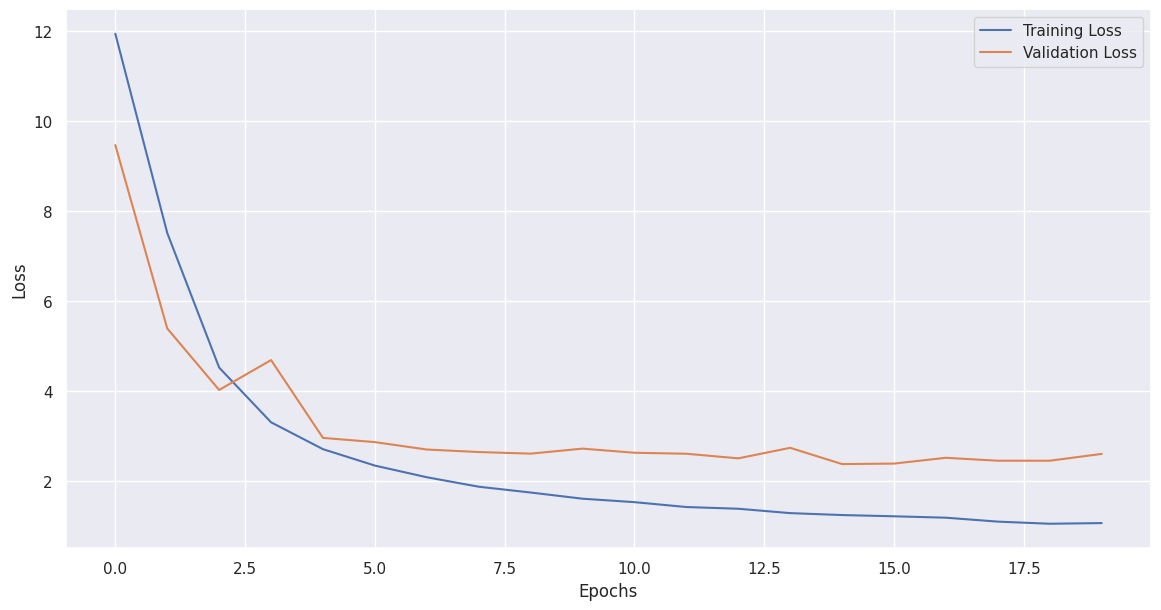

In [97]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [106]:
#history.history.keys()
loss_df = pd.DataFrame(data=history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,11.941380,0.056762,9.469188,0.121888
1,7.518315,0.181291,5.398099,0.236624
2,4.528499,0.285524,4.031527,0.307010
3,3.313314,0.363342,4.695305,0.313591
4,2.716911,0.422610,2.966749,0.434335


1/1 [==============================] - 0s 29ms/step
original_text =   things
predicted text = things

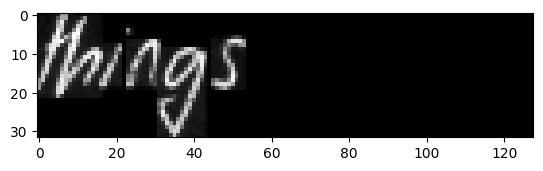



original_text =   ,
predicted text = ,

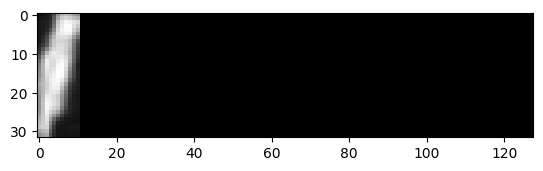



original_text =   and
predicted text = and

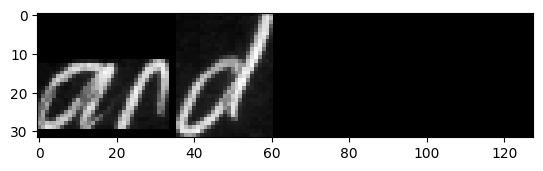



original_text =   in
predicted text = in

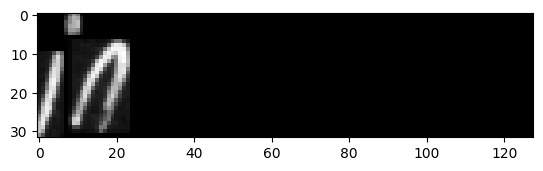



original_text =   any
predicted text = any

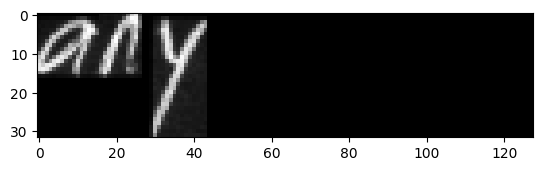

In [90]:
start_index = 0
end_index = 5

# Ensure the end_index is within the range of available test images
end_index = min(end_index, len(test_images))

test_prediction = act_model.predict(test_images[start_index:end_index])

# Use CTC decoder
test_decoded = K.ctc_decode(test_prediction,
                             input_length=np.ones(test_prediction.shape[0]) * test_prediction.shape[1],
                             greedy=True)[0][0]

test_out = K.get_value(test_decoded)

# plot
for i, x in enumerate(test_out):
    print("original_text =  ", test_original_text[start_index + i])
    print("predicted text = ", end='')
    for p in x:
        if int(p) != -1:
            print(char_set[int(p)], end='')
    plt.imshow(test_images[start_index + i].reshape(32, 128), cmap=plt.cm.gray)
    plt.show()
    print('\n')


103/103 [==============================] - 1s 13ms/step
original_text =   things
predicted text = things

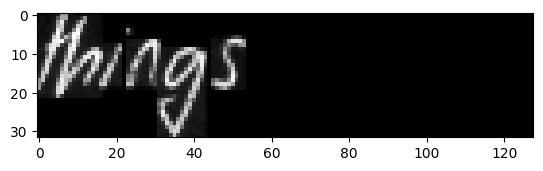



original_text =   ,
predicted text = ,

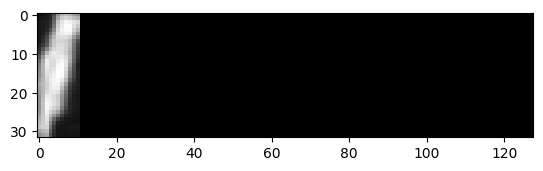



original_text =   and
predicted text = and

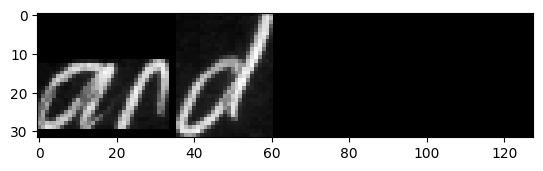



original_text =   in
predicted text = in

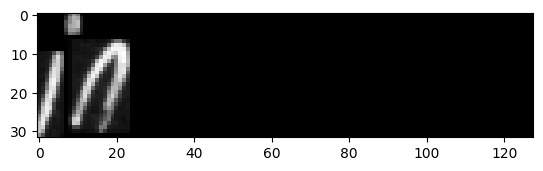



original_text =   any
predicted text = any

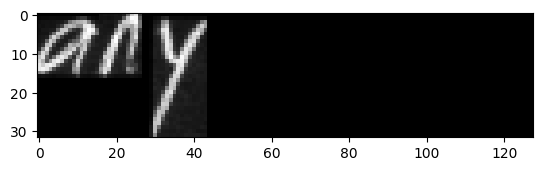



original_text =   case
predicted text = case

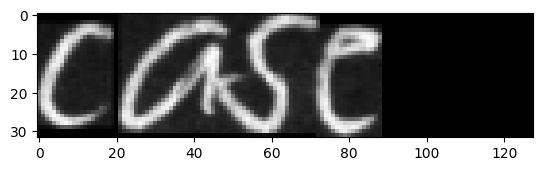



original_text =   may
predicted text = may

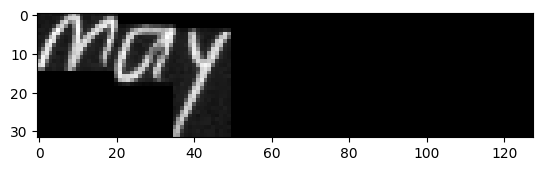



original_text =   be
predicted text = be

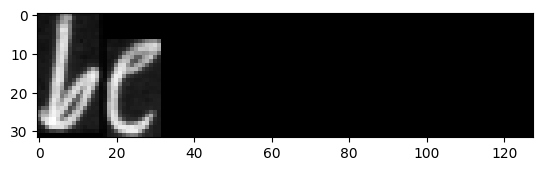



original_text =   regarded
predicted text = regarded

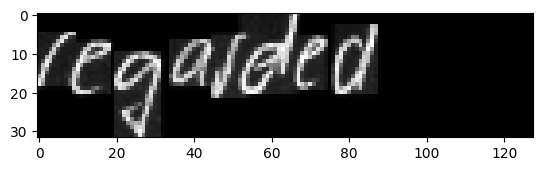



original_text =   as
predicted text = as

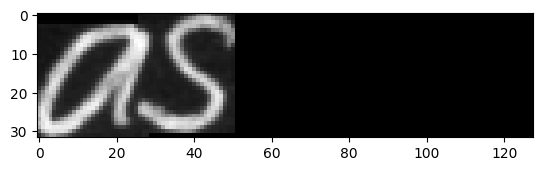



original_text =   a
predicted text = a

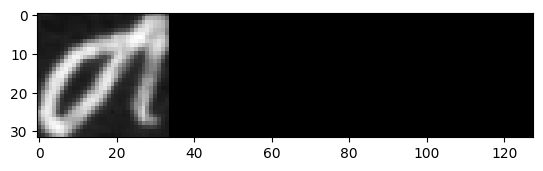



original_text =   good
predicted text = good

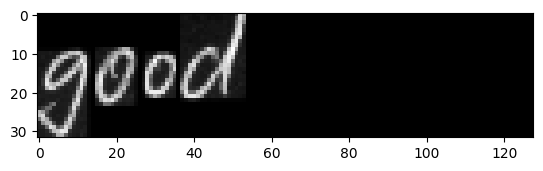



original_text =   beginning
predicted text = begining

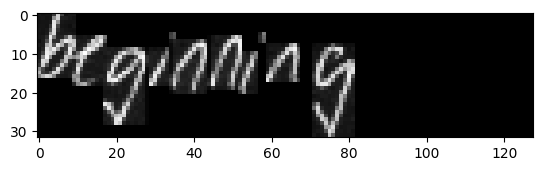



original_text =   to
predicted text = to

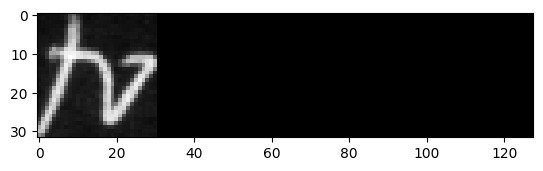



original_text =   which
predicted text = which

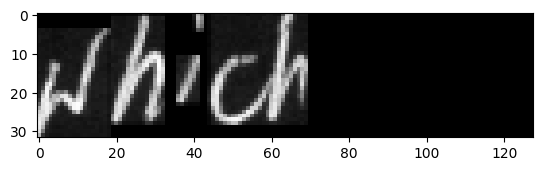



original_text =   other
predicted text = other

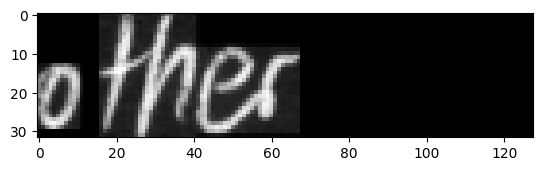



original_text =   tools
predicted text = toods

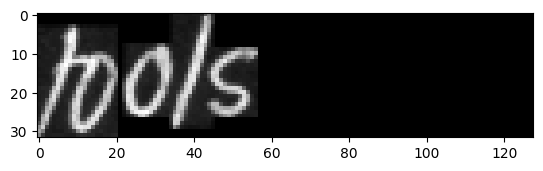



original_text =   can
predicted text = can

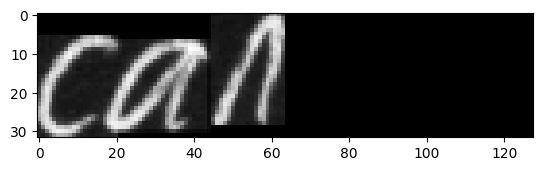



original_text =   be
predicted text = be

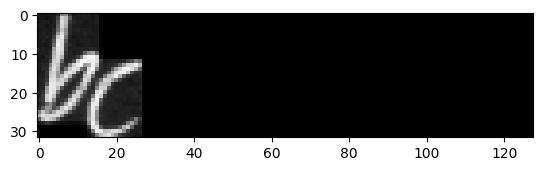



original_text =   added
predicted text = added

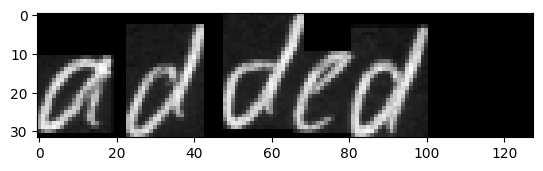



original_text =   as
predicted text = as

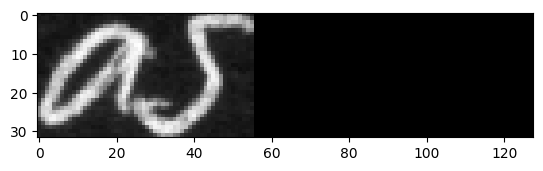



original_text =   the
predicted text = the

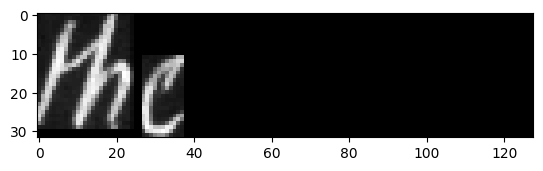



original_text =   need
predicted text = need

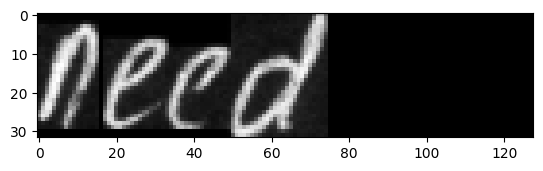



original_text =   arises
predicted text = ariver

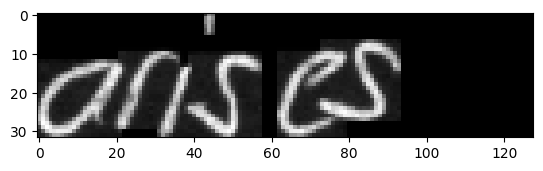



original_text =   .
predicted text = .

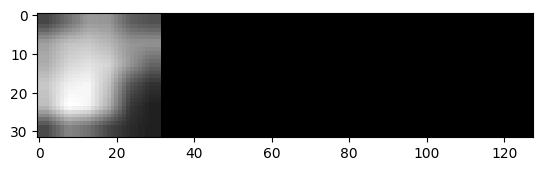



original_text =   The
predicted text = the

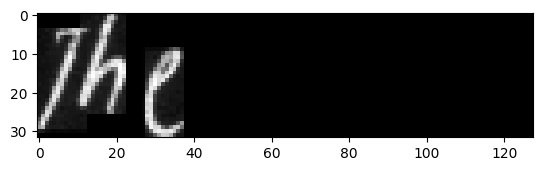



original_text =   nature
predicted text = nalure

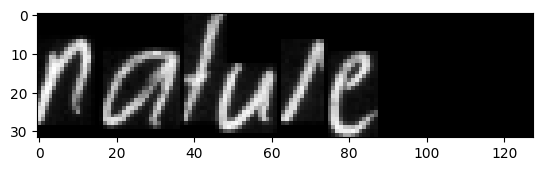



original_text =   of
predicted text = of

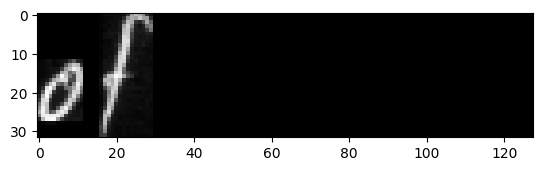



original_text =   the
predicted text = the

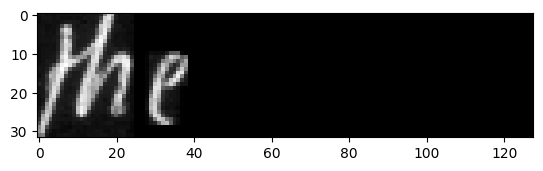



original_text =   work
predicted text = work

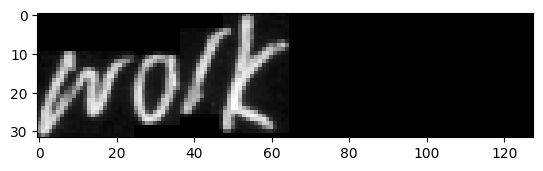



original_text =   will
predicted text = will

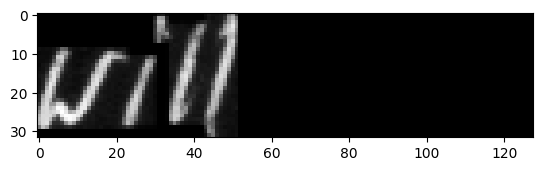



original_text =   probably
predicted text = provably

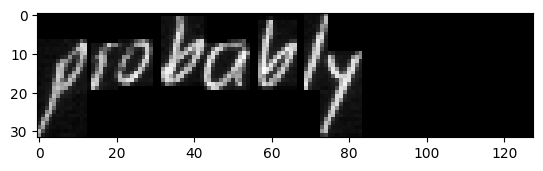



original_text =   dictate
predicted text = dictate

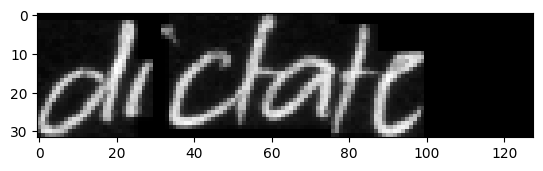



original_text =   the
predicted text = the

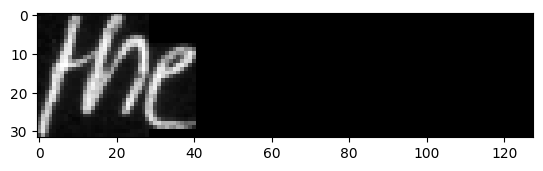



original_text =   additions
predicted text = additions

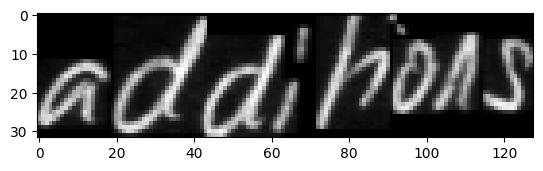



original_text =   to
predicted text = to

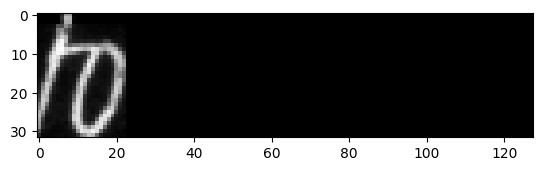



original_text =   be
predicted text = be

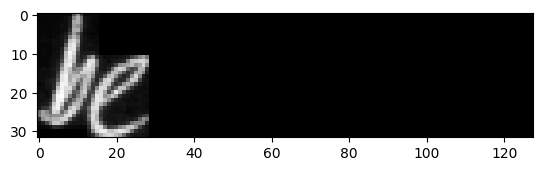



original_text =   made
predicted text = made

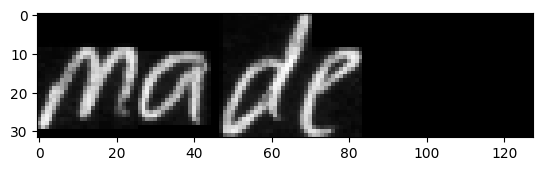



original_text =   ,
predicted text = ,

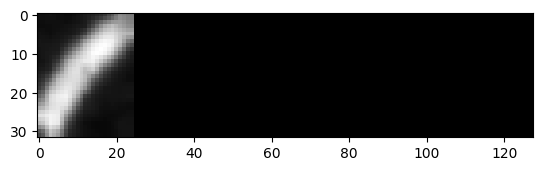



original_text =   but
predicted text = but

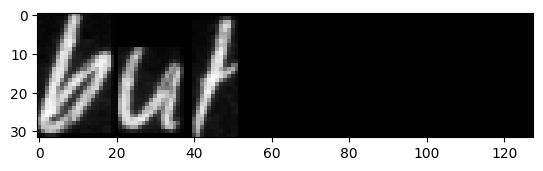



original_text =   as
predicted text = as

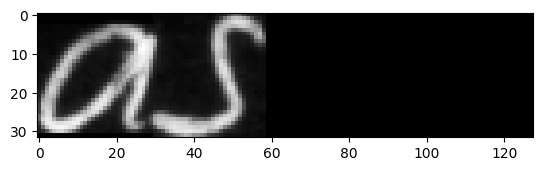



original_text =   a
predicted text = a

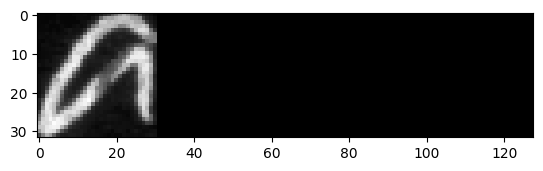



original_text =   guide
predicted text = quide

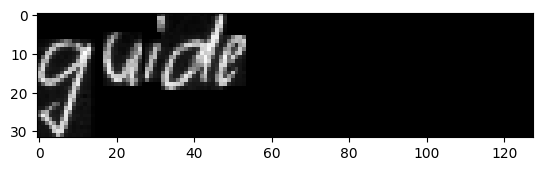



original_text =   we
predicted text = we

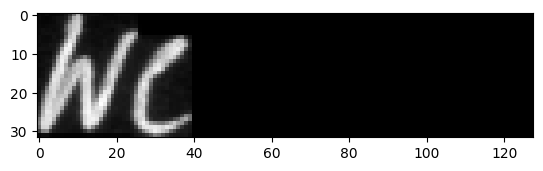



original_text =   have
predicted text = have

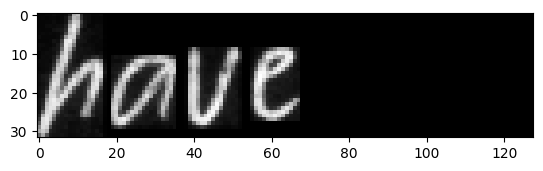



original_text =   given
predicted text = given

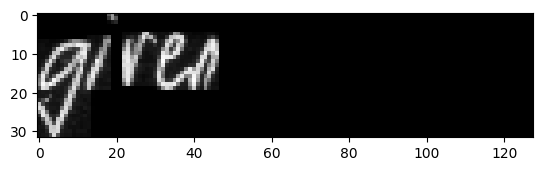



original_text =   a
predicted text = a

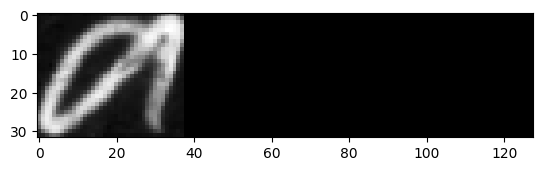



original_text =   fuller
predicted text = fuller

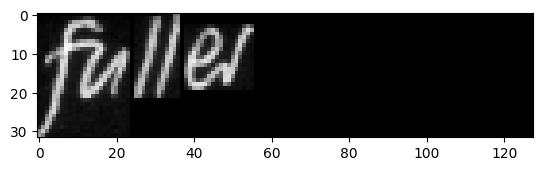



original_text =   kit
predicted text = lit

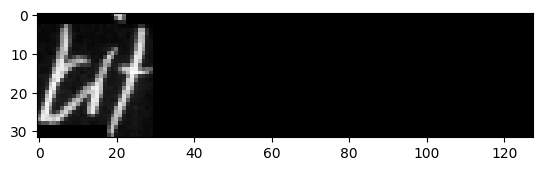



original_text =   which
predicted text = which

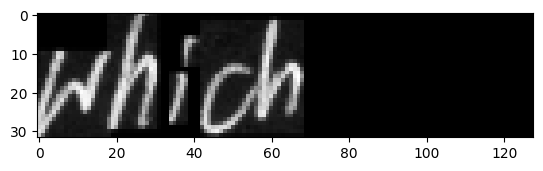



original_text =   increases
predicted text = incleases

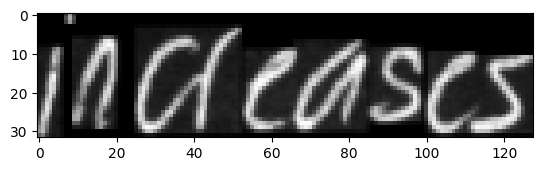



original_text =   the
predicted text = the

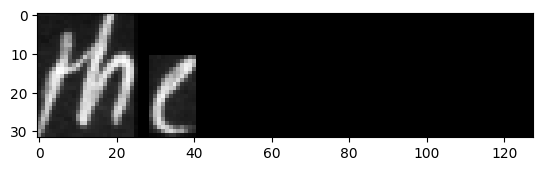



original_text =   range
predicted text = range

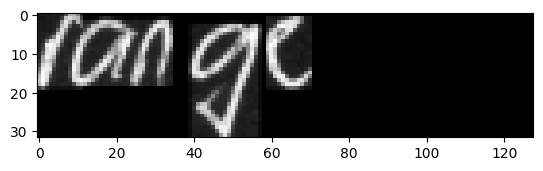



original_text =   of
predicted text = of

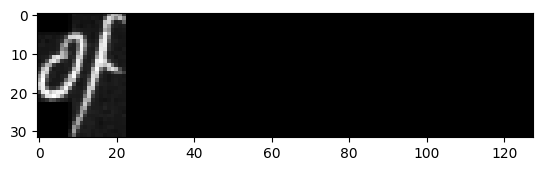



original_text =   things
predicted text = mhings

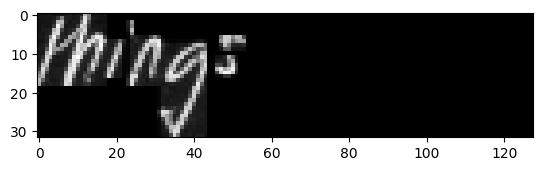



original_text =   that
predicted text = that

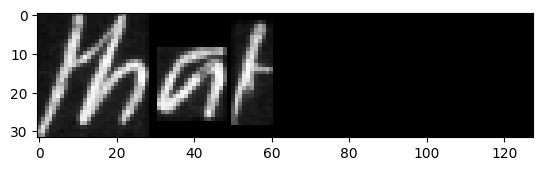



original_text =   can
predicted text = can

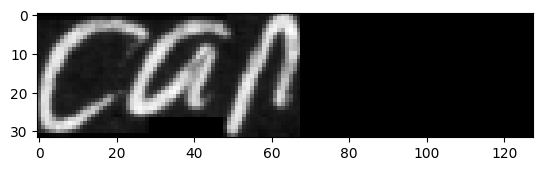



original_text =   be
predicted text = be

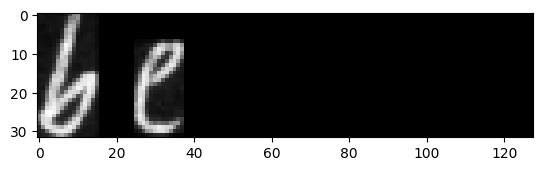



original_text =   made
predicted text = made

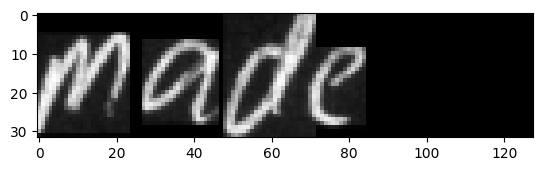



original_text =   enormously
predicted text = eormously

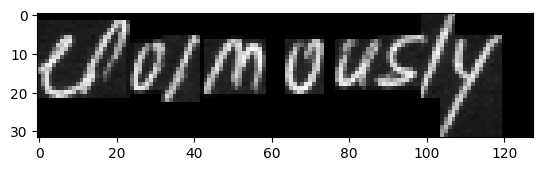



original_text =   .
predicted text = .

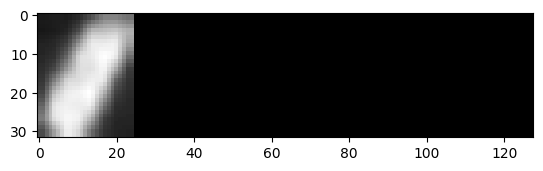



original_text =   As
predicted text = as

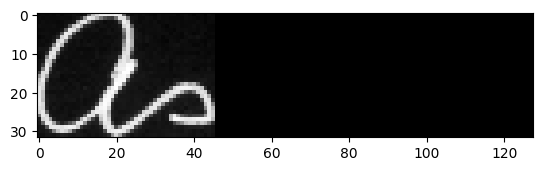



original_text =   a
predicted text = a

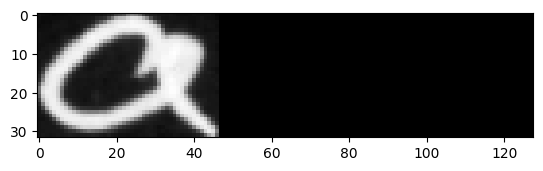



original_text =   still
predicted text = still

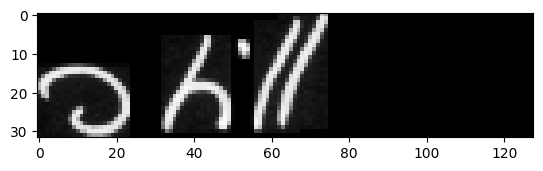



original_text =   further
predicted text = further

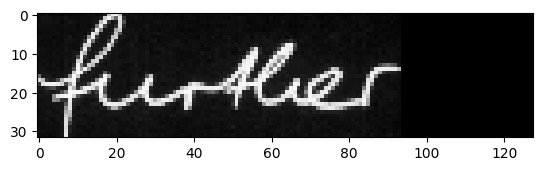



original_text =   development
predicted text = developmen

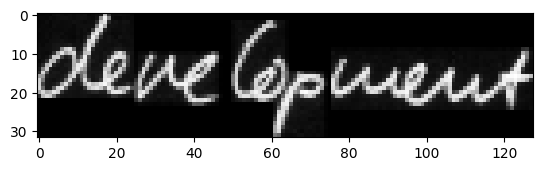



original_text =   ,
predicted text = ,

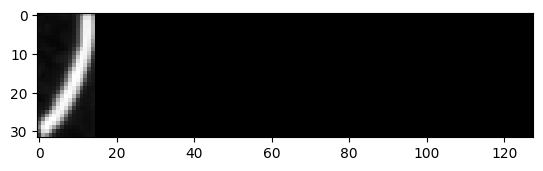



original_text =   we
predicted text = we

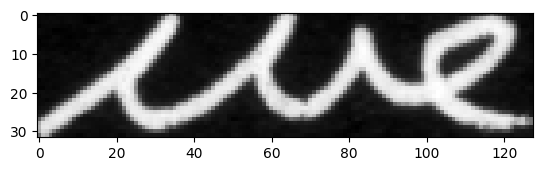



original_text =   follow
predicted text = follow

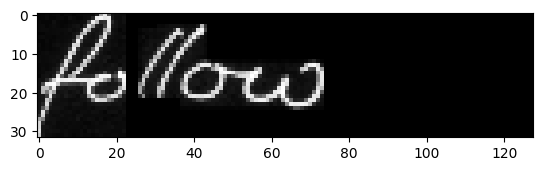



original_text =   with
predicted text = with

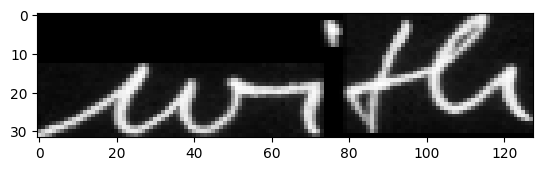



original_text =   a
predicted text = a

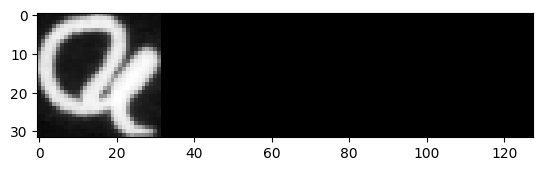



original_text =   good
predicted text = good

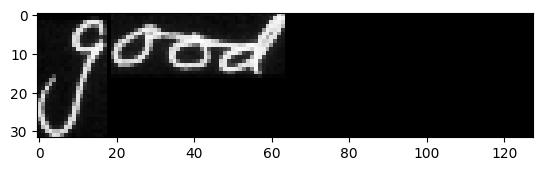



original_text =   basic
predicted text = brasic

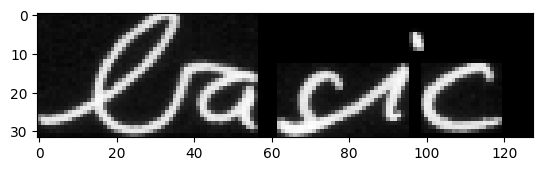



original_text =   kit
predicted text = lit

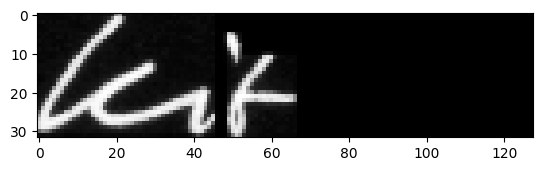



original_text =   ,
predicted text = ,

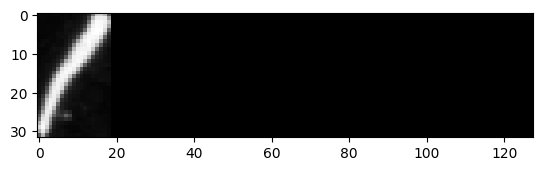



original_text =   which
predicted text = which

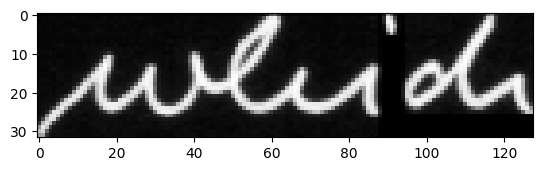



original_text =   includes
predicted text = includes

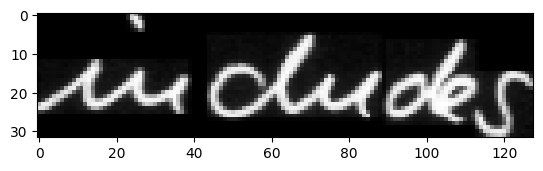



original_text =   With
predicted text = With

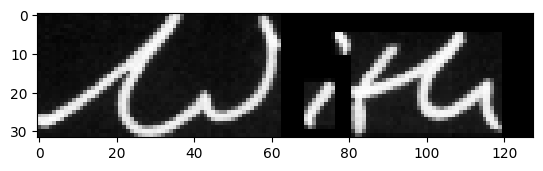



original_text =   this
predicted text = this

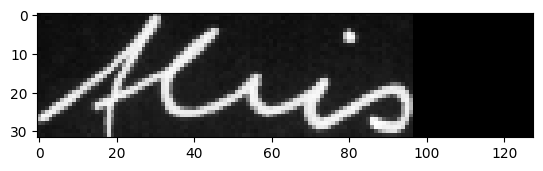



original_text =   the
predicted text = the

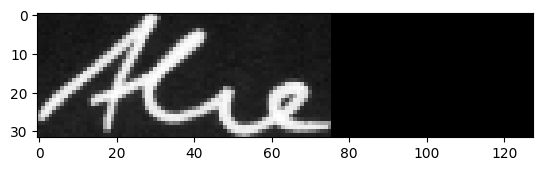



original_text =   vast
predicted text = last

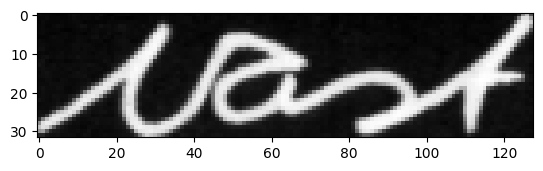



original_text =   majority
predicted text = majority

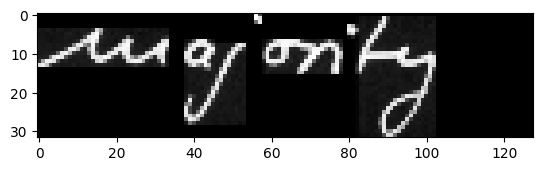



original_text =   of
predicted text = of

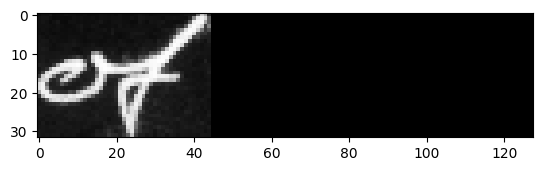



original_text =   jobs
predicted text = jirs

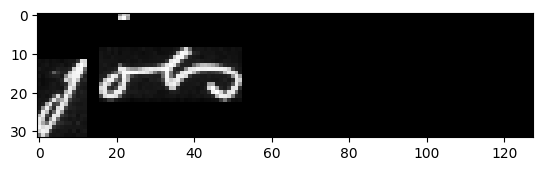



original_text =   can
predicted text = can

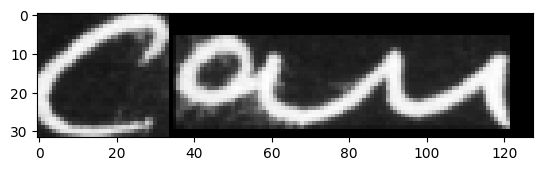



original_text =   be
predicted text = he

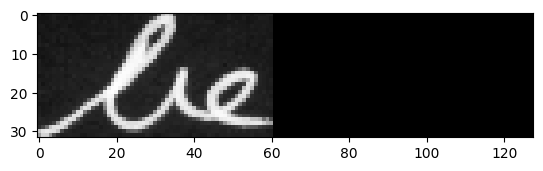



original_text =   done
predicted text = doue

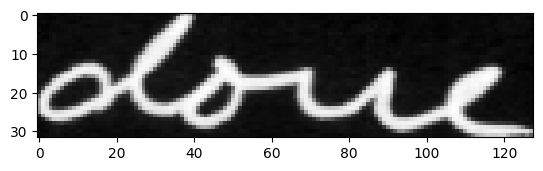



original_text =   ,
predicted text = ,

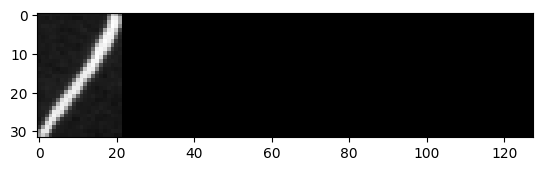



original_text =   though
predicted text = thouyh

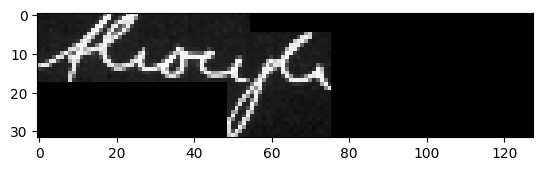



original_text =   for
predicted text = ffor

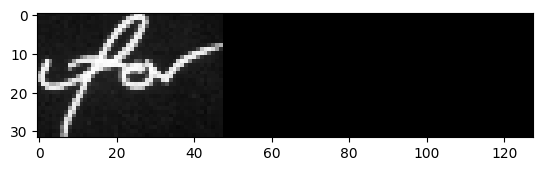



original_text =   advanced
predicted text = advrano

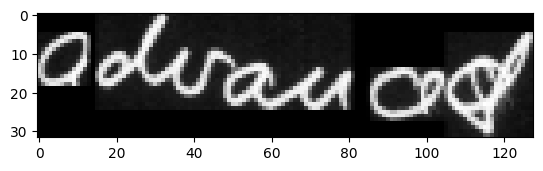



original_text =   cabinet
predicted text = Calricet

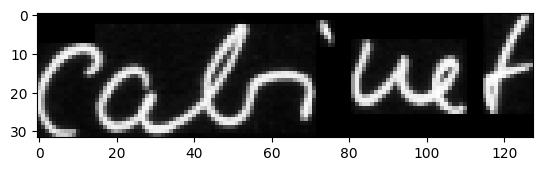



original_text =   work
predicted text = worke

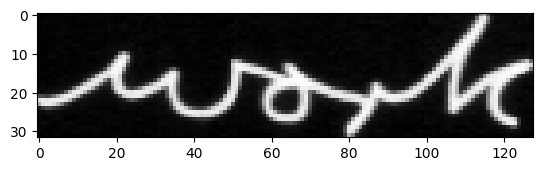



original_text =   the
predicted text = the

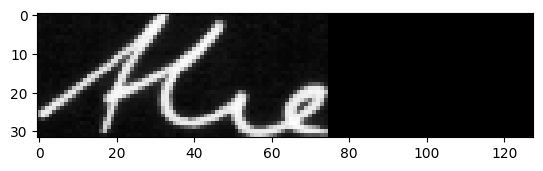



original_text =   necessity
predicted text = mecersity

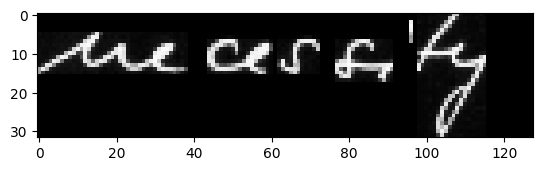



original_text =   for
predicted text = for

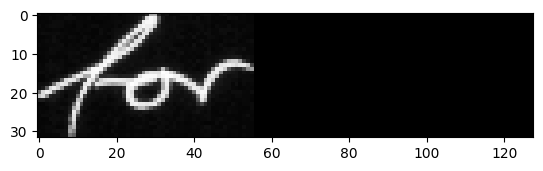



original_text =   certain
predicted text = certain

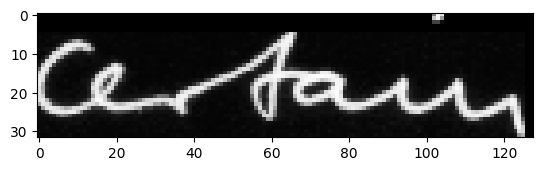



original_text =   special
predicted text = special

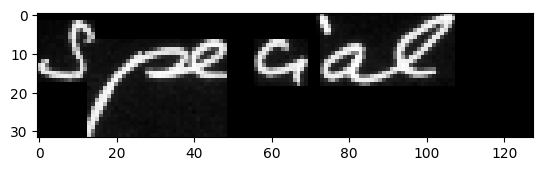



original_text =   tools
predicted text = fools

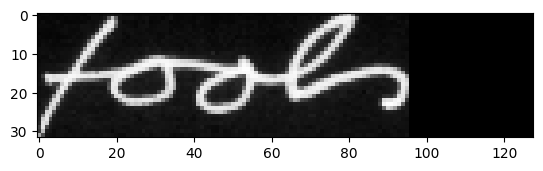



original_text =   will
predicted text = mill

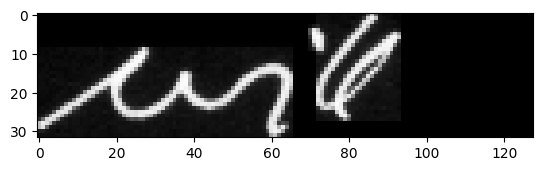



original_text =   become
predicted text = hocome

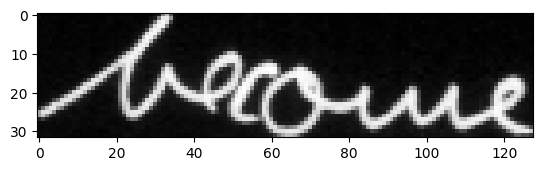



original_text =   obvious
predicted text = obvious

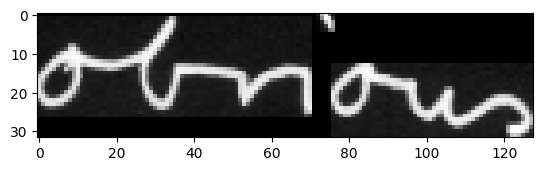



original_text =   .
predicted text = .

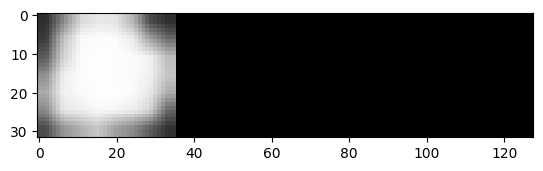



original_text =   Lastly
predicted text = Lastly

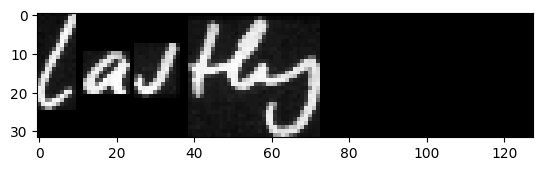



original_text =   ,
predicted text = ,

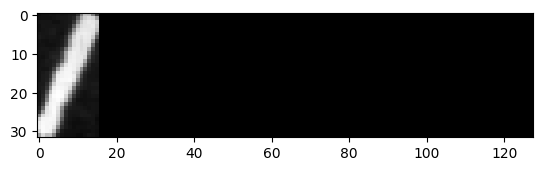



original_text =   we
predicted text = we

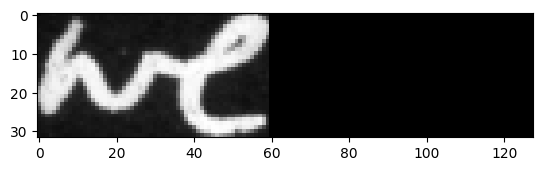



original_text =   suggest
predicted text = suggest

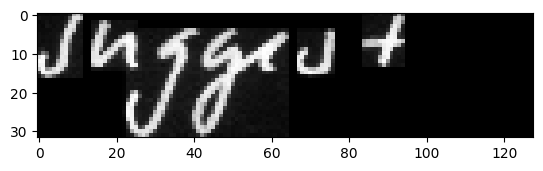



original_text =   certain
predicted text = certain

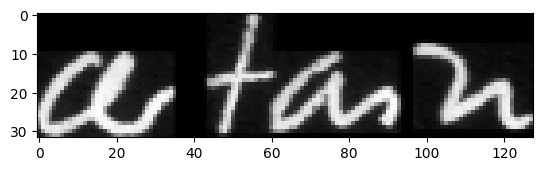



original_text =   power
predicted text = poner

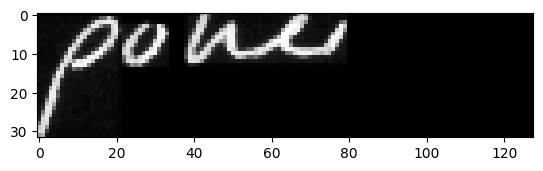



original_text =   tools
predicted text = tools

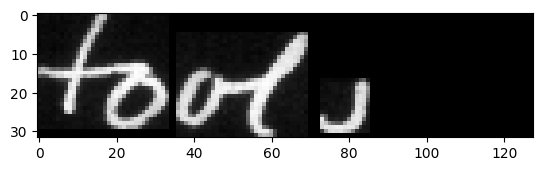



original_text =   and
predicted text = and

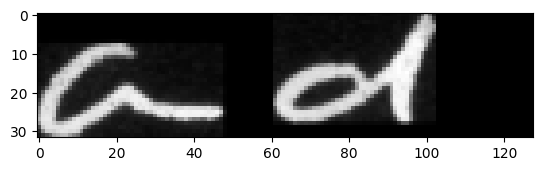



original_text =   machines
predicted text = machkney

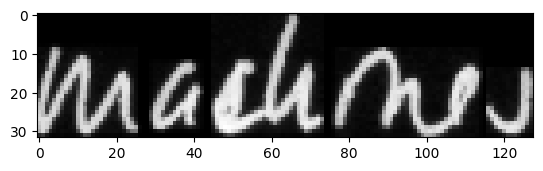



original_text =   ,
predicted text = ,

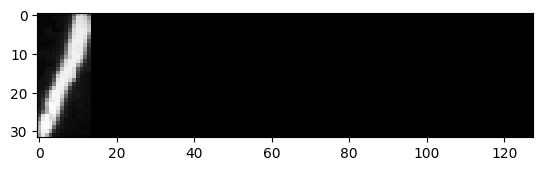



original_text =   the
predicted text = the

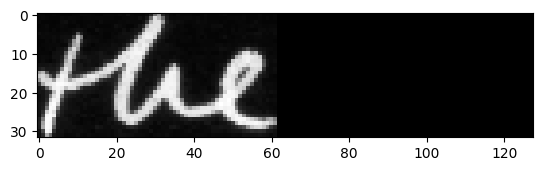



original_text =   choice
predicted text = daride

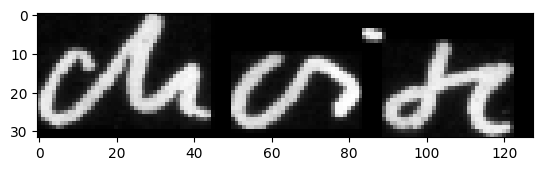



original_text =   of
predicted text = of

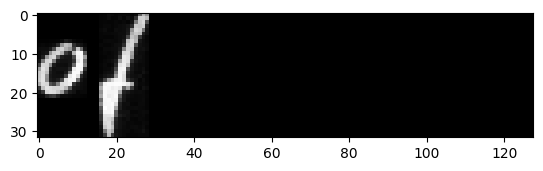



original_text =   which
predicted text = which

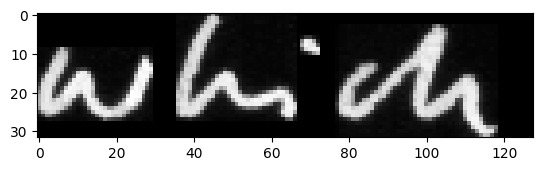



original_text =   will
predicted text = will

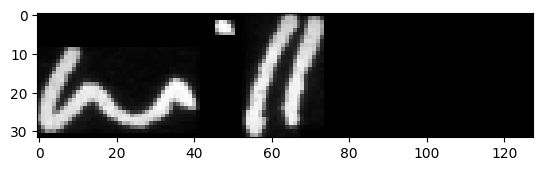



original_text =   depend
predicted text = deped

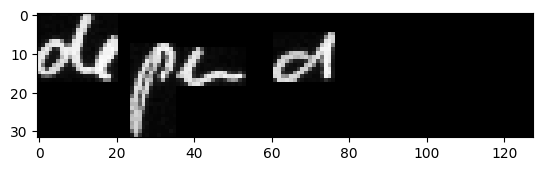



original_text =   partly
predicted text = putly

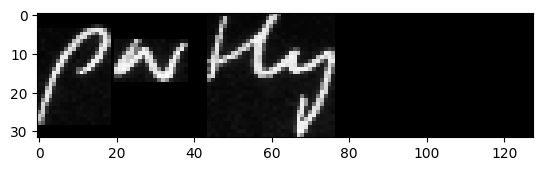



original_text =   upon
predicted text = upm

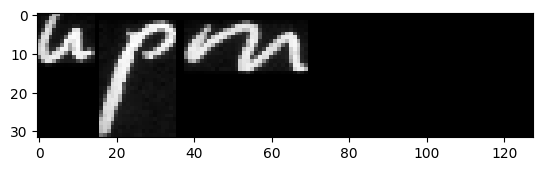



original_text =   the
predicted text = the

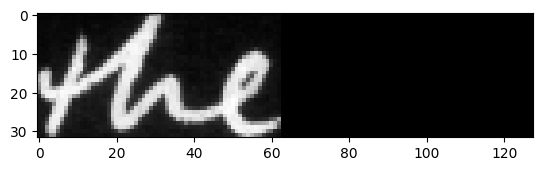



original_text =   space
predicted text = space

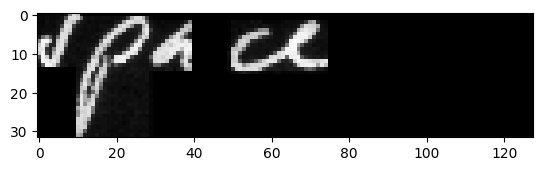



original_text =   available
predicted text = available

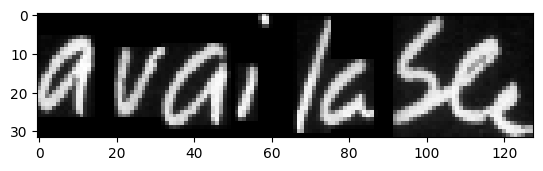



original_text =   in
predicted text = in

KeyboardInterrupt: 

In [91]:
test_prediction = act_model.predict(test_images)

# Use CTC decoder
test_decoded = K.ctc_decode(test_prediction,
                             input_length=np.ones(test_prediction.shape[0]) * test_prediction.shape[1],
                             greedy=True)[0][0]

test_out = K.get_value(test_decoded)

# Display results for test data
for i, x in enumerate(test_out):
    print("original_text =  ", test_original_text[i])
    print("predicted text = ", end='')
    for p in x:
        if int(p) != -1:
            print(char_set[int(p)], end='')
    plt.imshow(test_images[i].reshape(32, 128), cmap=plt.cm.gray)
    plt.show()
    print('\n')